In [1]:
!pip install xgboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from typing import List, Dict


## Import data and preprocess for XGBOOST Model

In [4]:
df = pd.read_csv("/content/drive/My Drive/climate5April/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')

In [5]:
df=df.loc[df['Date']>='2000-01-01']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 1800 to 2092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     293 non-null    datetime64[ns]
 1   Anomaly  293 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.9 KB


In [6]:
df=df.loc[df['Date']>='2000-01-01']

#### drop duplicate and resample data

In [7]:
# Drop duplicate values before resampling
df = df.drop_duplicates("Date")

# Set index, resample, and interpolate
df = df.set_index("Date").resample('D').interpolate(method='linear').reset_index()
df.head(2)


,Date,Anomaly
0,2000-01-01,0.320000
1,2000-01-02,0.327419


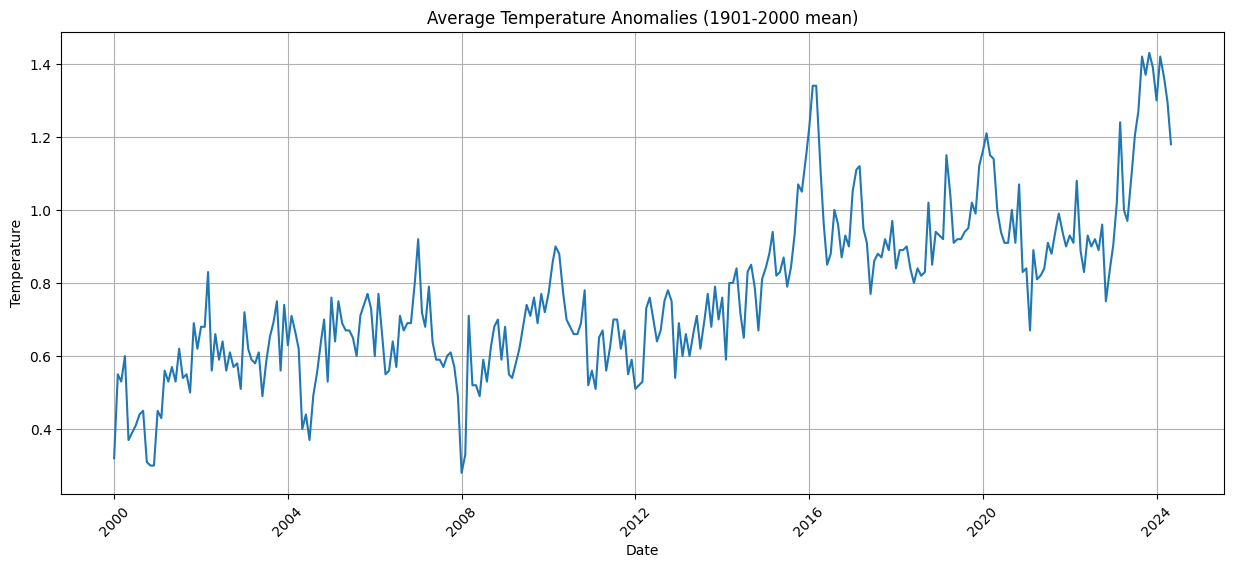

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Anomaly'], linestyle='-',alpha=1,lw=1.5)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average Temperature Anomalies (1901-2000 mean)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Define Preprocess Function for EFFECTIVE_DATE column

In [9]:

# Define DateFeatures and CyclicalFeatures transformers here
class DateFeatures(TransformerMixin, BaseEstimator):
    """DateFeatures transformer."""
    features = [
        "year",
        "day",
        "weekday",
        "month",
    ]

    def __init__(self):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names

    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)

        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

class CyclicalFeatures(TransformerMixin, BaseEstimator):
    """CyclicalFeatures transformer."""

    def __init__(self, max_vals: Dict[str, float] = {}):
        super().__init__()
        self.feature_names: List[str] = []
        self.max_vals = max_vals

    def get_feature_names(self):
        return self.feature_names

    def transform(self, df: pd.DataFrame):
        Xt = []
        for col in df.columns:
            if col in self.max_vals:
                max_val = self.max_vals[col]
            else:
                max_val = df[col].max()
            for fun_name, fun in [("cos", np.cos), ("sin", np.sin)]:
                date_feature = fun(2 * np.pi * df[col] / max_val)
                date_feature.name = f"{col}_{fun_name}"
                Xt.append(date_feature)

        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

preprocessor = ColumnTransformer(
    transformers=[
        (
            "DATE",
            make_pipeline(
                DateFeatures(),
                ColumnTransformer(
                    transformers=[
                        ("cyclical", CyclicalFeatures(), ["Date_day", "Date_weekday", "Date_month"])
                    ],
                    remainder="passthrough"
                )
            ),
            ["Date"],
        )
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        # Add your classifier/regressor here if needed
    ]
)
FEATURE_COLS = ["Date"]
date_features = pipeline.fit_transform(df[FEATURE_COLS])
date_features


array([[ 9.79529941e-01,  2.01298520e-01,  5.00000000e-01, ...,
         8.66025404e-01,  5.00000000e-01,  2.00000000e+03],
       [ 9.18957812e-01,  3.94355855e-01,  1.00000000e+00, ...,
         8.66025404e-01,  5.00000000e-01,  2.00000000e+03],
       [ 8.20763441e-01,  5.71268215e-01,  1.00000000e+00, ...,
         8.66025404e-01,  5.00000000e-01,  2.00000000e+03],
       ...,
       [ 9.18957812e-01, -3.94355855e-01,  1.00000000e+00, ...,
        -5.00000000e-01,  8.66025404e-01,  2.02400000e+03],
       [ 9.79529941e-01, -2.01298520e-01,  5.00000000e-01, ...,
        -5.00000000e-01,  8.66025404e-01,  2.02400000e+03],
       [ 9.79529941e-01,  2.01298520e-01, -5.00000000e-01, ...,
        -8.66025404e-01,  5.00000000e-01,  2.02400000e+03]])

#### Create Train and test split data

In [10]:
TRAIN_SIZE = int(len(df) * 0.9)
HORIZON = 1
TARGET_COL = "Anomaly"

X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]

In [11]:
y_train

,Anomaly
1,0.320000
2,0.327419
3,0.334839
4,0.342258
5,0.349677
...,...
7994,0.916000
7995,0.914667
7996,0.913333
7997,0.912000


In [12]:
len(y_test)

888

### Create a pipeline and define XGBOOST Model

In [13]:
from xgboost import XGBRegressor

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("xgb", XGBRegressor(objective="reg:squarederror", reg_lambda=45,n_estimators=100))
    ]
)
pipeline.fit(X_train[FEATURE_COLS], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('DATE',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['Date_day',
                                                                                                     'Date_weekday',
                                                                                                     'Date_month'])]))]),
                                                  ['Date'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### Set Horizon and process data for Predict

In [14]:
MAX_HORIZON = 1
X_test_horizon = pd.Series(pd.date_range(
    start=df.Date.min(),
    periods=len(df) + MAX_HORIZON,
    name="Date"
)).reset_index()

#### Predict data

In [15]:
forecasted = pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])), pd.Series(X_test_horizon.Date)],
    axis=1
)
forecasted.columns = [TARGET_COL, "Date"]

#### Prepare Real data for plotting

In [16]:
actual = pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.Date)],
    axis=1
)
actual.columns = [TARGET_COL, "Date"]

#### plot the result

Text(0.5, 1.0, 'Global Land and Ocean Average Temperature Anomalies Forecasting (XGBOOST Model)')

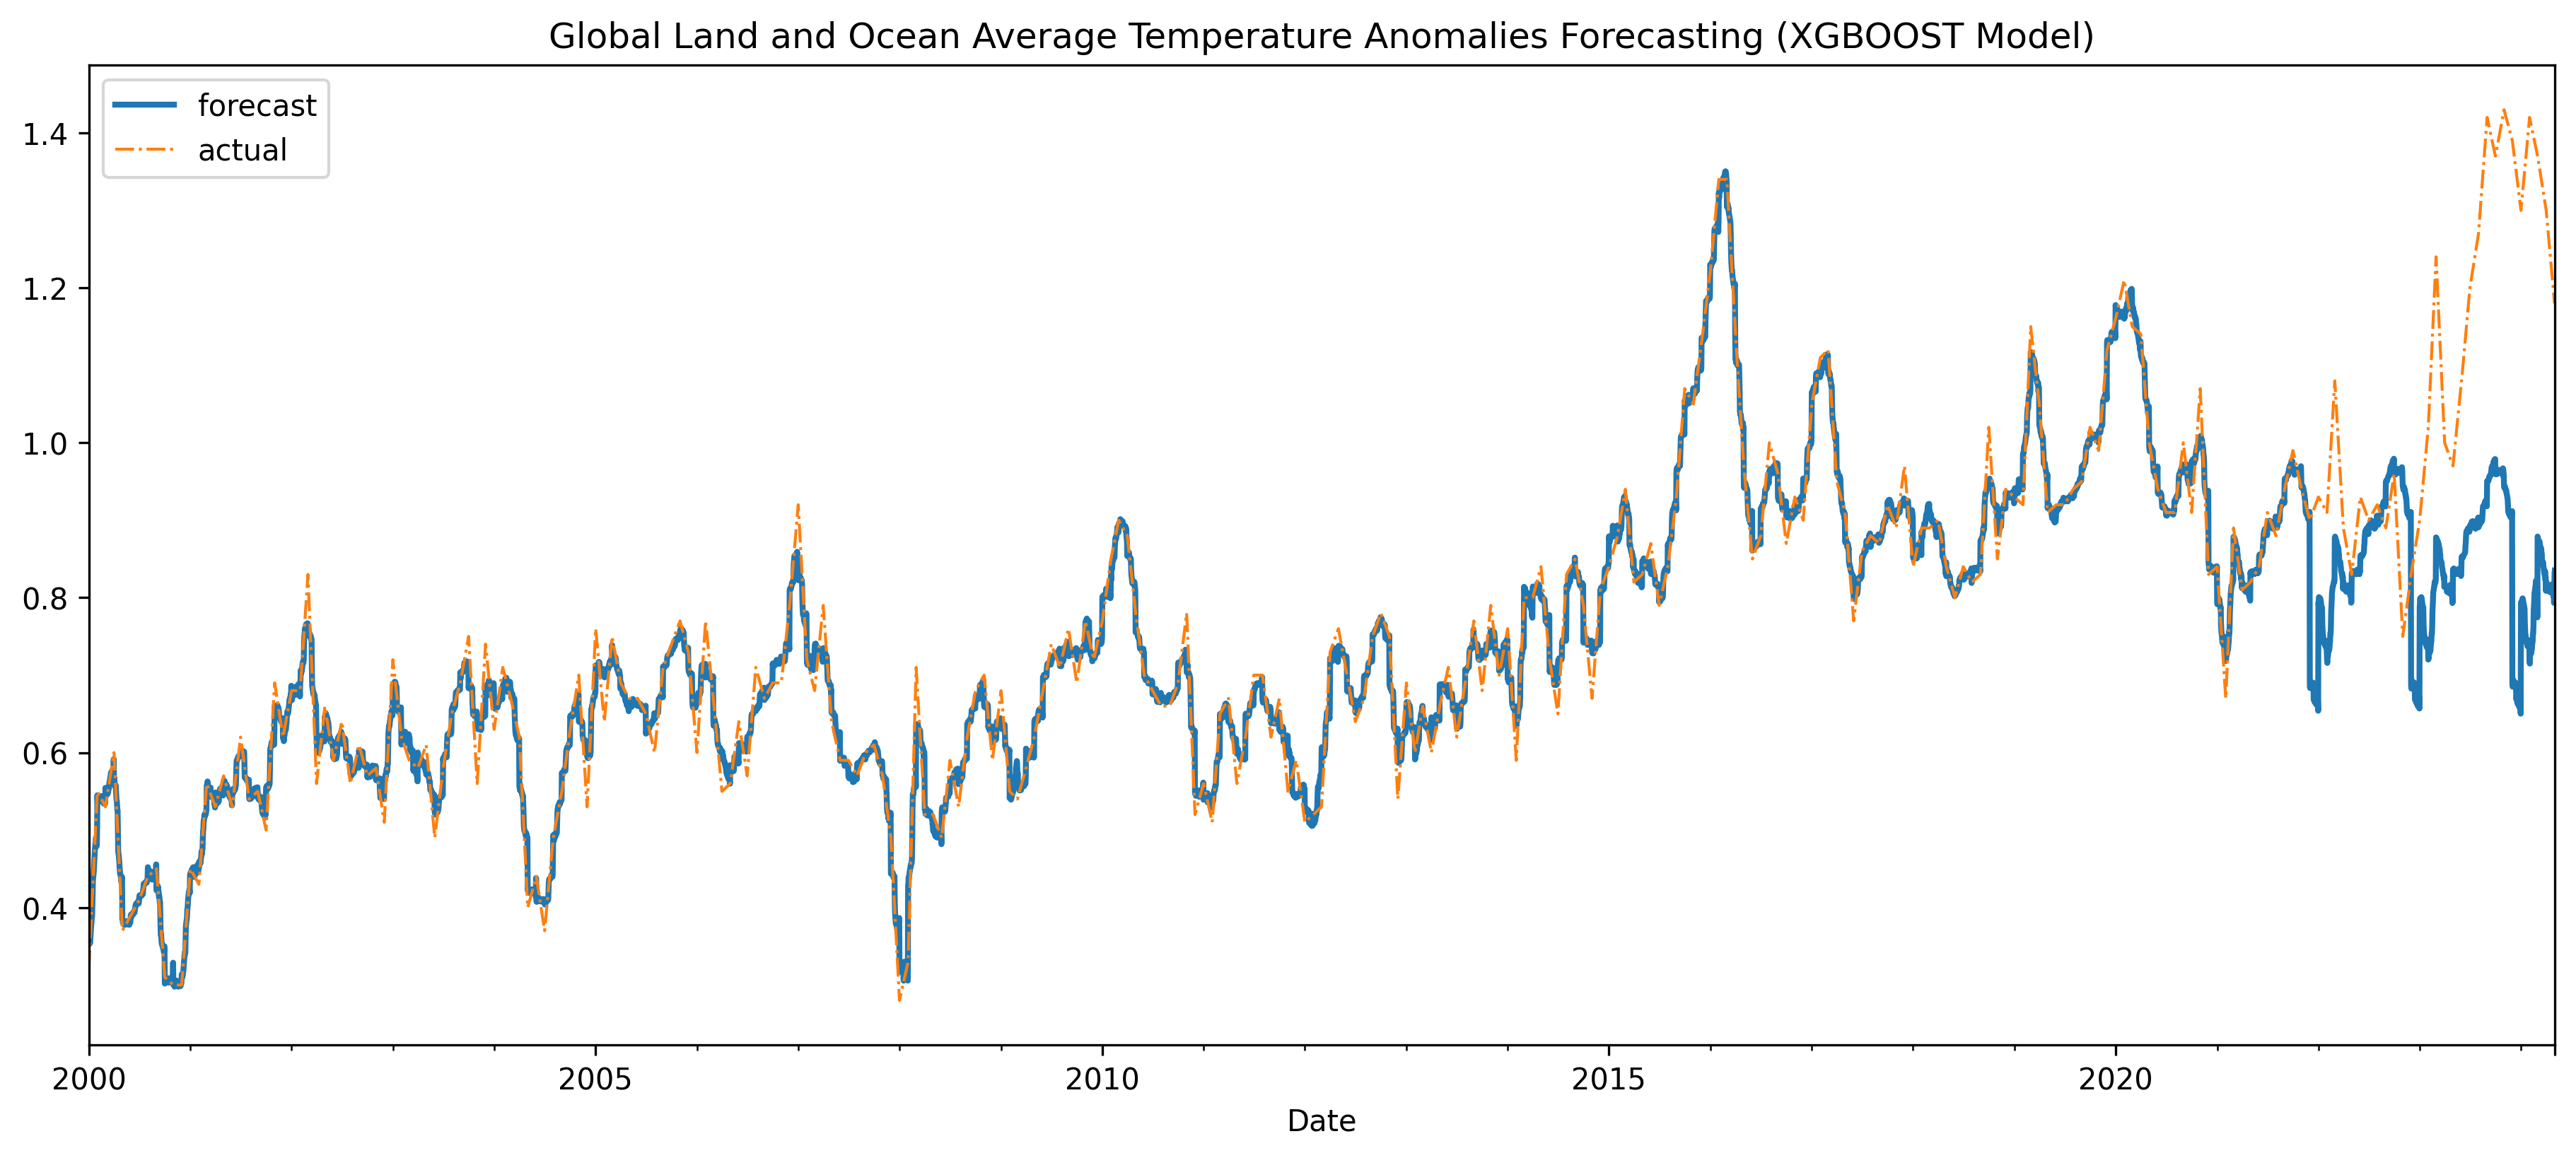

In [20]:
fig, ax = plt.subplots(figsize=(15, 6),dpi=300)
forecasted.set_index("Date").plot( ax=ax,lw=2)
actual.set_index("Date").plot(linestyle='-.', ax=ax,lw=1)
plt.legend(["forecast", "actual"])
plt.title('Global Land and Ocean Average Temperature Anomalies Forecasting (XGBOOST Model)')

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Merge actual and forecasted data
test_data = actual.merge(forecasted, on="Date", suffixes=("_actual", "_predicted"))

# Calculate metrics
mse = mean_squared_error(test_data.Anomaly_actual, test_data.Anomaly_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data.Anomaly_actual, test_data.Anomaly_predicted)
r2 = r2_score(test_data.Anomaly_actual, test_data.Anomaly_predicted)

# Print results
print("Mean Squared Error (MSE) on test set: {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE) on test set: {:.4f}".format(rmse))
print("Mean Absolute Error (MAE) on test set: {:.4f}".format(mae))
print("R-squared (R²) on test set: {:.4f}".format(r2))


Mean Squared Error (MSE) on test set: 0.0111
Root Mean Squared Error (RMSE) on test set: 0.1055
Mean Absolute Error (MAE) on test set: 0.0391
R-squared (R²) on test set: 0.7635


# Fine Tune XGBoost Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid for XGBoostRegressor
param_grid = {
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train[FEATURE_COLS], y_train)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test[FEATURE_COLS])
test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE:", test_mse)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found: {'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 3, 'xgb__subsample': 0.9}
Test MSE: 17.696651342152247


#### Train model with best HyperParameters

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# Define the best parameters found
best_params = {
    'colsample_bytree': 0.9,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 3,
    'subsample': 0.9
}

# Create XGBRegressor with best parameters
best_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=1000, **best_params)

# Define the pipeline with preprocessing and the best XGBRegressor
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("xgb", best_xgb)
])

# Fit the pipeline to the training data
pipeline.fit(X_train[FEATURE_COLS], y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('DATE',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['Date_day',
                                                                                                     'Date_weekday',
                                                                                                     'Date_month'])]))]),
                                                  ['Date'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])